# PointPainting Demo - KITTI Dataset

This notebook demonstrates the PointPainting implementation for 3D object detection using RGB-LiDAR fusion on the KITTI dataset.

## Overview

PointPainting is a sequential fusion method that:
1. **Semantic Segmentation**: Generates pixel-wise class predictions from RGB images
2. **Point Projection**: Projects 3D LiDAR points onto the 2D image plane
3. **Point Painting**: Augments each 3D point with semantic class scores

The painted point cloud can then be used with any LiDAR-based 3D detector.

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add src directory to path
sys.path.append(str(Path().absolute().parent / "src"))

from pointpainting import (
    PointPainter,
    SemanticSegmentationModel,
    PointCloudProjector,
    KITTIDataLoader,
    visualize_results,
    visualize_3d_pointcloud,
    compute_metrics,
    save_painted_pointcloud
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PyTorch version: 2.8.0+cpu
CUDA available: False


## Configuration

Set up paths and parameters for the experiment.

In [2]:
# Configuration
KITTI_ROOT = r"D:\datasets\kitti"  # Update this path to your KITTI dataset
OUTPUT_DIR = "../outputs/pointpainting_demo"
SAMPLE_ID = "000000"  # Sample to process

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Dataset Setup

Initialize the KITTI data loader and inspect the dataset structure.

In [3]:
# Initialize KITTI data loader
try:
    data_loader = KITTIDataLoader(KITTI_ROOT, split="training")
    print(f"Successfully loaded KITTI dataset with {len(data_loader)} samples")
    print(f"Available sample IDs: {data_loader.sample_ids[:10]}...")  # Show first 10
    
    # Check class distribution
    class_dist = data_loader.get_class_distribution()
    print("\nClass distribution in dataset:")
    for class_name, count in class_dist.items():
        print(f"  {class_name}: {count}")
        
except Exception as e:
    print(f"Error loading KITTI dataset: {e}")
    print("Please check the KITTI_ROOT path and ensure the dataset is properly extracted.")
    print("Expected structure:")
    print("  KITTI_ROOT/training/")
    print("    ├── velodyne/")
    print("    ├── image_2/")
    print("    ├── calib/")
    print("    └── label_2/")

INFO:pointpainting.data_loader:Initialized KITTI loader for training split with 7481 samples


Successfully loaded KITTI dataset with 7481 samples
Available sample IDs: ['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009']...

Class distribution in dataset:
  Pedestrian: 4487
  Truck: 1094
  Car: 28742
  Cyclist: 1627
  DontCare: 11295
  Misc: 973
  Van: 2914
  Tram: 511
  Person_sitting: 222

Class distribution in dataset:
  Pedestrian: 4487
  Truck: 1094
  Car: 28742
  Cyclist: 1627
  DontCare: 11295
  Misc: 973
  Van: 2914
  Tram: 511
  Person_sitting: 222


## Load Sample Data

Load a specific KITTI sample including point cloud, image, calibration, and labels.

In [4]:
# Load sample data
print(f"Loading KITTI sample {SAMPLE_ID}...")

try:
    sample_data = data_loader.load_sample(SAMPLE_ID)
    
    point_cloud = sample_data["point_cloud"]
    image = sample_data["image"]
    camera_matrix = sample_data["camera_matrix"]
    transform_matrix = sample_data["transform_matrix"]
    labels = sample_data["labels"]
    
    print(f"Point cloud shape: {point_cloud.shape}")
    print(f"Image shape: {image.shape}")
    print(f"Camera matrix shape: {camera_matrix.shape}")
    print(f"Transform matrix shape: {transform_matrix.shape}")
    print(f"Number of labeled objects: {len(labels)}")
    
    # Show object types in this sample
    if labels:
        object_types = [obj['type'] for obj in labels]
        print(f"Object types: {set(object_types)}")
        
except Exception as e:
    print(f"Error loading sample: {e}")

Loading KITTI sample 000000...
Point cloud shape: (115384, 4)
Image shape: (370, 1224, 3)
Camera matrix shape: (3, 4)
Transform matrix shape: (4, 4)
Number of labeled objects: 1
Object types: {'Pedestrian'}
Point cloud shape: (115384, 4)
Image shape: (370, 1224, 3)
Camera matrix shape: (3, 4)
Transform matrix shape: (4, 4)
Number of labeled objects: 1
Object types: {'Pedestrian'}


## Visualize Input Data

Display the original RGB image and point cloud.

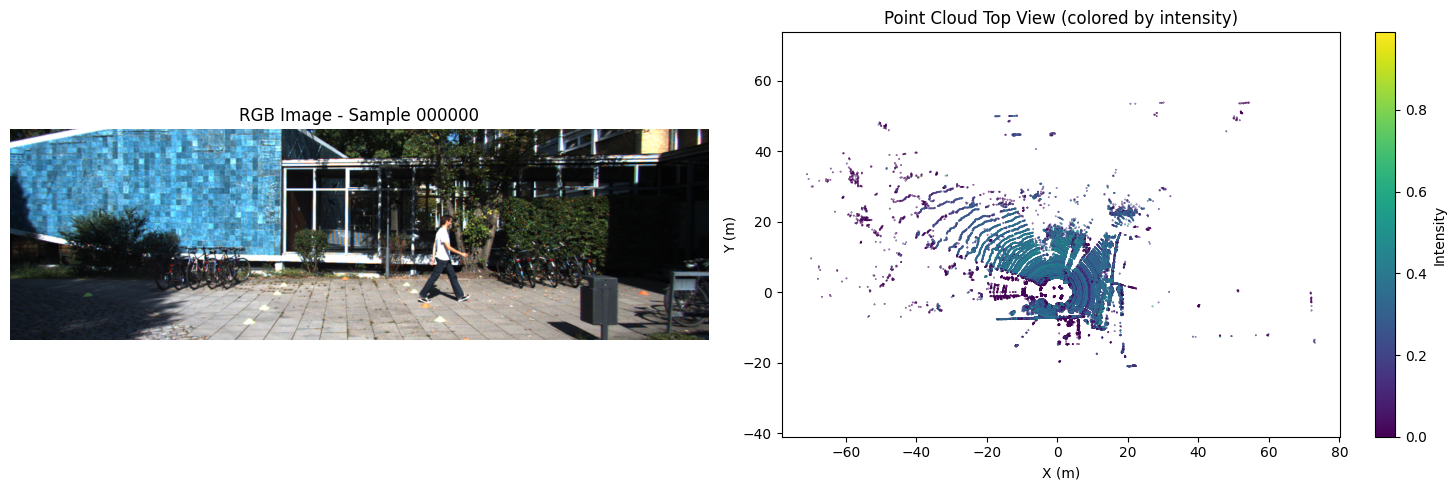

Point cloud statistics:
  Total points: 115384
  X range: [-71.0, 73.0] m
  Y range: [-21.1, 53.8] m
  Z range: [-5.2, 2.7] m
  Intensity range: [0.000, 0.990]


In [5]:
# Visualize input data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Show RGB image
axes[0].imshow(image)
axes[0].set_title(f"RGB Image - Sample {SAMPLE_ID}")
axes[0].axis('off')

# Show point cloud top view
pc_2d = point_cloud[:, :2]  # X, Y coordinates
intensities = point_cloud[:, 3]  # Intensity values

scatter = axes[1].scatter(pc_2d[:, 0], pc_2d[:, 1], c=intensities, s=0.1, cmap='viridis')
axes[1].set_title("Point Cloud Top View (colored by intensity)")
axes[1].set_xlabel("X (m)")
axes[1].set_ylabel("Y (m)")
axes[1].axis('equal')
plt.colorbar(scatter, ax=axes[1], label="Intensity")

plt.tight_layout()
plt.show()

print(f"Point cloud statistics:")
print(f"  Total points: {len(point_cloud)}")
print(f"  X range: [{point_cloud[:, 0].min():.1f}, {point_cloud[:, 0].max():.1f}] m")
print(f"  Y range: [{point_cloud[:, 1].min():.1f}, {point_cloud[:, 1].max():.1f}] m")
print(f"  Z range: [{point_cloud[:, 2].min():.1f}, {point_cloud[:, 2].max():.1f}] m")
print(f"  Intensity range: [{point_cloud[:, 3].min():.3f}, {point_cloud[:, 3].max():.3f}]")

## Initialize PointPainting Components

Set up the semantic segmentation model, point projector, and main PointPainter.

In [6]:
# Initialize PointPainting components
print("Initializing PointPainting components...")

# Class names for KITTI
class_names = ["background", "car", "pedestrian", "cyclist"]

# 1. Semantic Segmentation Model
print("Loading semantic segmentation model...")
segmentation_model = SemanticSegmentationModel(
    num_classes=len(class_names),
    device=device,
    pretrained=True
)

# 2. Point Cloud Projector
projector = PointCloudProjector(filter_behind_camera=True)

# 3. Main PointPainter
painter = PointPainter(
    segmentation_model=segmentation_model,
    projector=projector,
    device=device,
    class_names=class_names
)

print("PointPainting components initialized successfully!")

Initializing PointPainting components...
Loading semantic segmentation model...


c:\Users\Caspe\Documents\Semester 9\EIRT\eirt2025\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Caspe\Documents\Semester 9\EIRT\eirt2025\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pointpainting.segmentation:Initialized deeplabv3_resnet50 with 4 classes on cpu
INFO:pointpainting.core:PointPainter initialized with 4 classes on cpu
INFO:pointpainting.segmentation:Initialized deeplabv3_resnet50 with 4 classes on cpu
INFO:pointpainting.core:PointPainter i

PointPainting components initialized successfully!


## Step 1: Semantic Segmentation

Generate pixel-wise semantic segmentation from the RGB image.

Running semantic segmentation...
Segmentation scores shape: (370, 1224, 4)
Score range: [0.155, 0.418]
Segmentation scores shape: (370, 1224, 4)
Score range: [0.155, 0.418]


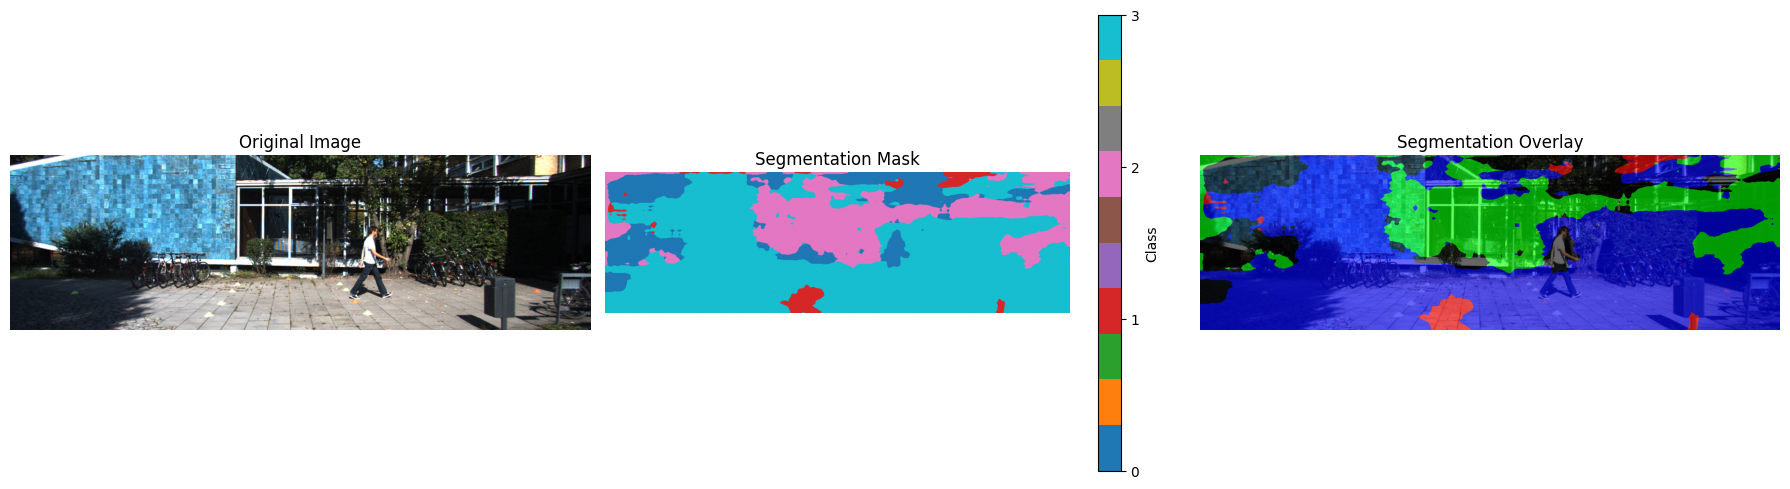


Class distribution in segmentation:
  background: 65508 pixels (14.5%)
  car: 11585 pixels (2.6%)
  pedestrian: 99474 pixels (22.0%)
  cyclist: 276313 pixels (61.0%)


In [7]:
# Run semantic segmentation
print("Running semantic segmentation...")

segmentation_scores = segmentation_model.predict(
    image, 
    return_probabilities=True,
    temperature=1.0
)

print(f"Segmentation scores shape: {segmentation_scores.shape}")
print(f"Score range: [{segmentation_scores.min():.3f}, {segmentation_scores.max():.3f}]")

# Get predicted classes
predicted_classes = segmentation_model.get_class_predictions(segmentation_scores)

# Create visualization
segmentation_viz = segmentation_model.visualize_segmentation(
    image, segmentation_scores, alpha=0.6
)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Segmentation mask
im = axes[1].imshow(predicted_classes, cmap='tab10')
axes[1].set_title("Segmentation Mask")
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], ticks=range(len(class_names)), 
             label="Class", shrink=0.8)

# Overlay visualization
axes[2].imshow(segmentation_viz)
axes[2].set_title("Segmentation Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print class distribution in segmentation
unique_classes, counts = np.unique(predicted_classes, return_counts=True)
print("\nClass distribution in segmentation:")
for cls, count in zip(unique_classes, counts):
    percentage = count / predicted_classes.size * 100
    print(f"  {class_names[cls]}: {count} pixels ({percentage:.1f}%)")

## Step 2: Point Cloud Projection

Project 3D LiDAR points onto the 2D image plane.

Projecting point cloud to image...
Projection statistics:
  total_points: 115384
  valid_points: 20249
  valid_percentage: 17.549226929210292
  mean_distance: 12.752757104225516
  min_distance: 5.5585136782791
  max_distance: 74.1106885982159

Visualizing point projection...


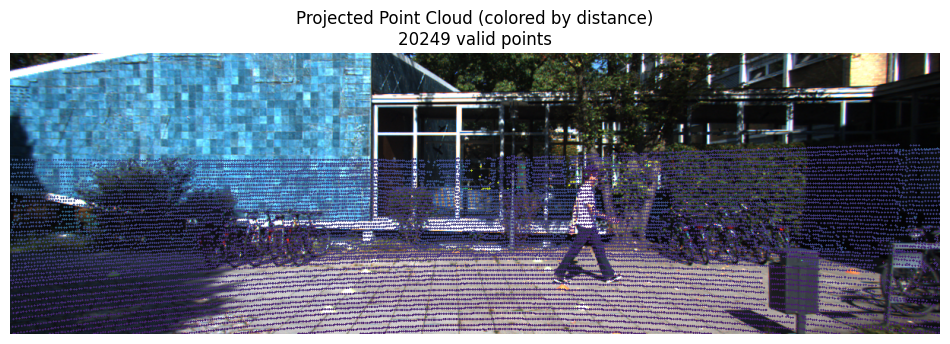

In [9]:
# Project point cloud to image
print("Projecting point cloud to image...")

projection_results = projector.project_points(
    points_3d=point_cloud[:, :3],
    camera_matrix=camera_matrix,
    transform_matrix=transform_matrix,
    image_shape=image.shape[:2],
    min_distance=1.0,
    max_distance=80.0
)

projected_points = projection_results["projected_points"]
valid_mask = projection_results["valid_mask"]
distances = projection_results["distances"]

# Get projection statistics
proj_stats = projector.get_projection_statistics(projection_results)
print(f"Projection statistics:")
for key, value in proj_stats.items():
    print(f"  {key}: {value}")

# Visualize projection
print("\nVisualizing point projection...")

# Create colors based on distance for ALL points, then filter
distance_colors_all = plt.cm.viridis(distances / distances.max())
distance_colors_all = (distance_colors_all[:, :3] * 255).astype(np.uint8)

projected_vis = projector.visualize_projection(
    image=image,
    projected_points=projected_points,
    valid_mask=valid_mask,
    point_colors=distance_colors_all,  # Pass colors for all points, will be filtered internally
    point_size=1
)

plt.figure(figsize=(12, 8))
plt.imshow(projected_vis)
plt.title(f"Projected Point Cloud (colored by distance)\n{valid_mask.sum()} valid points")
plt.axis('off')
plt.show()

## Step 3: Point Painting (Fusion)

Run the complete PointPainting pipeline to augment points with semantic information.

In [10]:
# Run complete PointPainting pipeline
print("Running PointPainting pipeline...")

painting_results = painter.paint_pointcloud(
    point_cloud=point_cloud,
    image=image,
    camera_matrix=camera_matrix,
    transform_matrix=transform_matrix,
    return_painted_points=True,
    return_segmentation=True
)

painted_points = painting_results["painted_points"]
segmentation_scores = painting_results["segmentation_scores"]
projected_points = painting_results["projected_points"]
valid_mask = painting_results["valid_mask"]

print(f"Painted point cloud shape: {painted_points.shape}")
print(f"Original features: {point_cloud.shape[1]} -> Painted features: {painted_points.shape[1]}")
print(f"Added semantic dimensions: {painted_points.shape[1] - point_cloud.shape[1]}")

# Extract semantic features and predictions
semantic_features = painted_points[:, 4:]  # Skip x, y, z, intensity
predicted_point_classes = np.argmax(semantic_features, axis=1)
prediction_confidence = np.max(semantic_features, axis=1)

print(f"\nSemantic feature statistics:")
print(f"  Feature range: [{semantic_features.min():.3f}, {semantic_features.max():.3f}]")
print(f"  Mean confidence: {prediction_confidence.mean():.3f}")
print(f"  Std confidence: {prediction_confidence.std():.3f}")

INFO:pointpainting.core:Processing point cloud with 115384 points and image of shape (370, 1224, 3)


Running PointPainting pipeline...


INFO:pointpainting.core:Generated segmentation with shape (370, 1224, 4)
INFO:pointpainting.core:Projected 20249 valid points out of 115384
INFO:pointpainting.core:Projected 20249 valid points out of 115384
INFO:pointpainting.core:Painted point cloud shape: (115384, 8)
INFO:pointpainting.core:Painted point cloud shape: (115384, 8)


Painted point cloud shape: (115384, 8)
Original features: 4 -> Painted features: 8
Added semantic dimensions: 4

Semantic feature statistics:
  Feature range: [0.000, 1.000]
  Mean confidence: 0.879
  Std confidence: 0.263


## Results Analysis

Analyze the results of the PointPainting process.

Class distribution in painted point cloud:
  background: 97048 points (84.1%)
  car: 390 points (0.3%)
  pedestrian: 3245 points (2.8%)
  cyclist: 14701 points (12.7%)


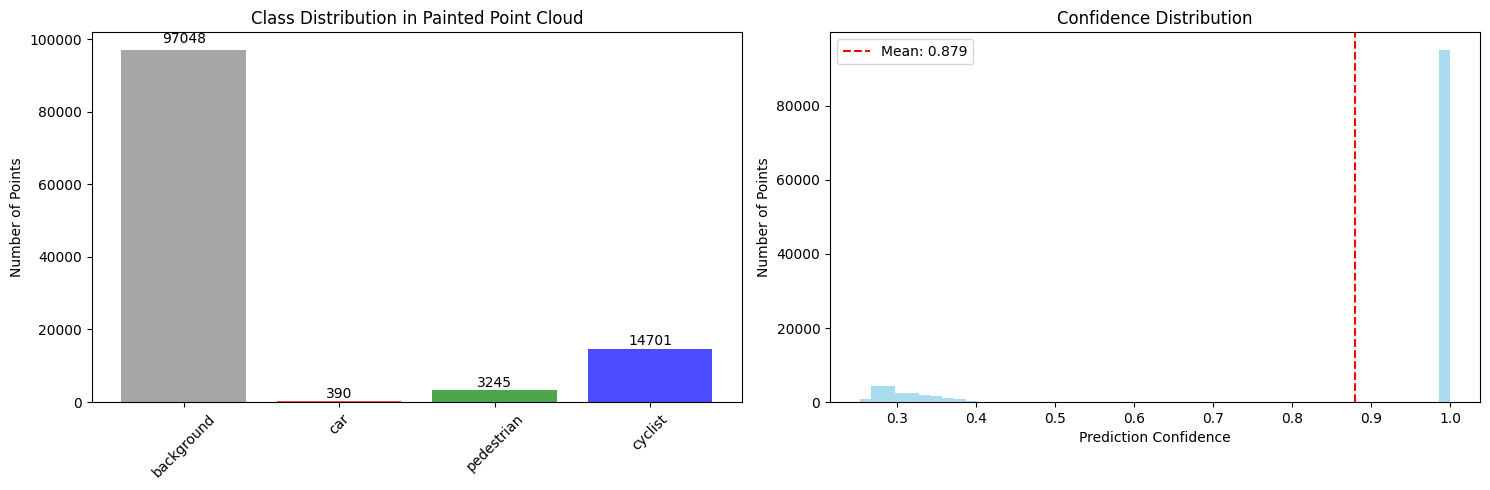

In [11]:
# Compute class statistics
class_stats = painter.get_class_statistics(painted_points)

print("Class distribution in painted point cloud:")
for class_name, stats in class_stats.items():
    print(f"  {class_name}: {stats['count']} points ({stats['percentage']:.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Class distribution bar chart
class_counts = [stats['count'] for stats in class_stats.values()]
colors = ['gray', 'red', 'green', 'blue']  # Match class colors

bars = axes[0].bar(range(len(class_names)), class_counts, color=colors, alpha=0.7)
axes[0].set_xticks(range(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_ylabel("Number of Points")
axes[0].set_title("Class Distribution in Painted Point Cloud")

# Add count labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count}', ha='center', va='bottom')

# Confidence distribution
axes[1].hist(prediction_confidence, bins=50, alpha=0.7, color='skyblue')
axes[1].axvline(prediction_confidence.mean(), color='red', linestyle='--', 
               label=f'Mean: {prediction_confidence.mean():.3f}')
axes[1].set_xlabel("Prediction Confidence")
axes[1].set_ylabel("Number of Points")
axes[1].set_title("Confidence Distribution")
axes[1].legend()

plt.tight_layout()
plt.show()

## Comprehensive Visualization

Create a comprehensive visualization showing all aspects of the PointPainting results.

Creating comprehensive visualization...


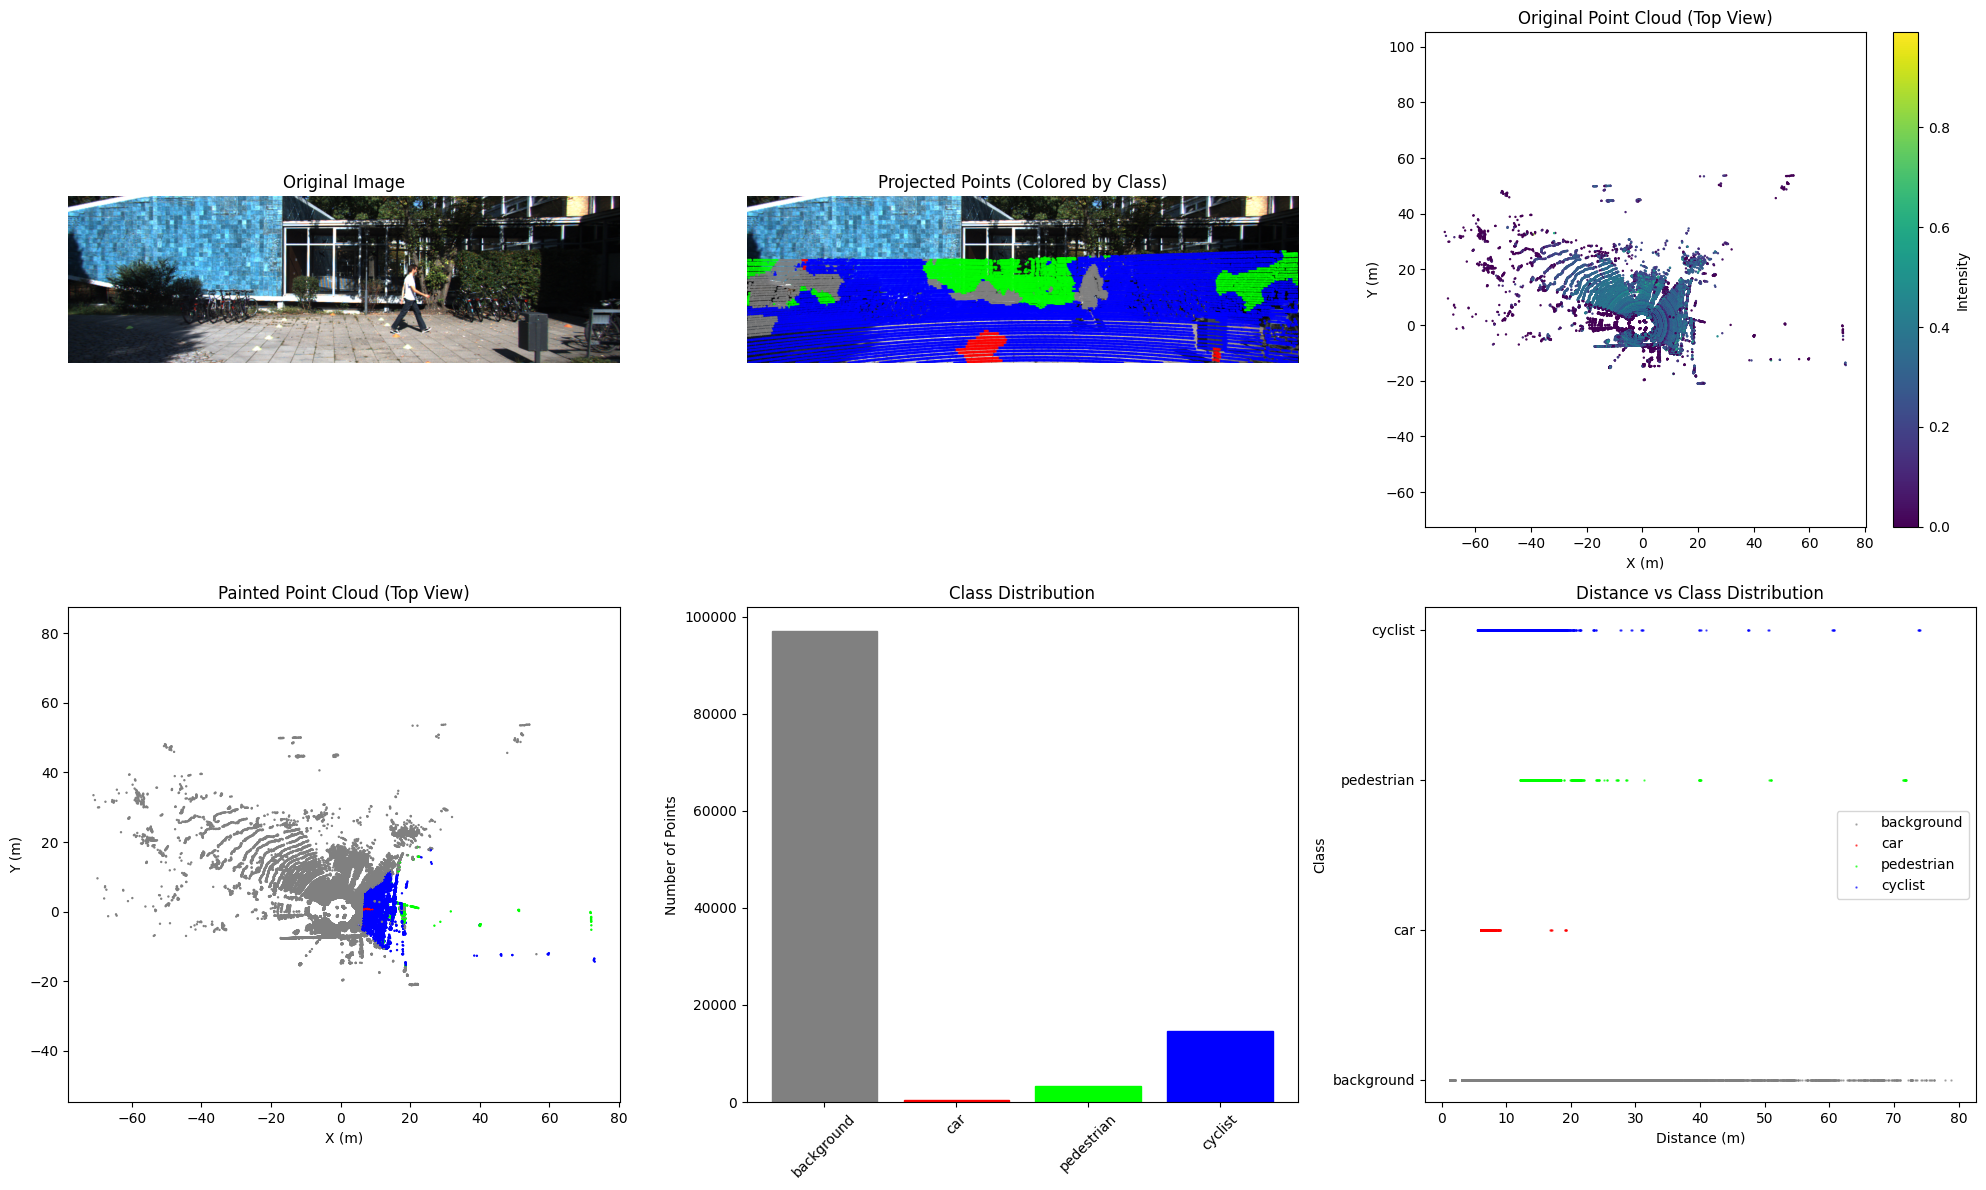

In [12]:
# Create comprehensive visualization
print("Creating comprehensive visualization...")

# Prepare projection results for visualization
projection_result = {
    "projected_points": projected_points,
    "valid_mask": valid_mask,
    "distances": distances
}

# Create the visualization
visualize_results(
    image=image,
    point_cloud=point_cloud,
    painted_points=painted_points,
    projection_result=projection_result,
    class_names=class_names,
    save_path=None  # Display instead of save
)

## Save Results

Save the painted point cloud and evaluation metrics.

In [13]:
# Save painted point cloud
print("Saving results...")

# Save as binary format (KITTI style)
painted_bin_path = os.path.join(OUTPUT_DIR, f"painted_pointcloud_{SAMPLE_ID}.bin")
save_painted_pointcloud(painted_points, painted_bin_path, format="bin")

# Save as NumPy array for easy loading
painted_npy_path = os.path.join(OUTPUT_DIR, f"painted_pointcloud_{SAMPLE_ID}.npy")
save_painted_pointcloud(painted_points, painted_npy_path, format="npy")

# Save comprehensive visualization
vis_path = os.path.join(OUTPUT_DIR, f"pointpainting_results_{SAMPLE_ID}.png")
visualize_results(
    image=image,
    point_cloud=point_cloud,
    painted_points=painted_points,
    projection_result=projection_result,
    class_names=class_names,
    save_path=vis_path
)

# Compute and save metrics
metrics = compute_metrics(
    painted_points=painted_points,
    class_names=class_names
)

# Save metrics to file
metrics_path = os.path.join(OUTPUT_DIR, f"metrics_{SAMPLE_ID}.txt")
with open(metrics_path, 'w') as f:
    f.write(f"PointPainting Metrics for Sample {SAMPLE_ID}\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Total points: {metrics['total_points']}\n")
    f.write(f"Number of classes: {metrics['num_classes']}\n")
    f.write(f"Mean confidence: {metrics['mean_confidence']:.3f}\n")
    f.write(f"Std confidence: {metrics['std_confidence']:.3f}\n\n")
    f.write("Class Distribution:\n")
    for class_name, stats in metrics["class_distribution"].items():
        f.write(f"  {class_name}: {stats['count']} points ({stats['percentage']:.1f}%)\n")

print(f"Results saved to {OUTPUT_DIR}:")
print(f"  - Painted point cloud (binary): {painted_bin_path}")
print(f"  - Painted point cloud (numpy): {painted_npy_path}")
print(f"  - Visualization: {vis_path}")
print(f"  - Metrics: {metrics_path}")

INFO:pointpainting.utils:Saved painted point cloud to ..\outputs\pointpainting_demo\painted_pointcloud_000000.bin
INFO:pointpainting.utils:Saved painted point cloud to ..\outputs\pointpainting_demo\painted_pointcloud_000000.npy
INFO:pointpainting.utils:Saved painted point cloud to ..\outputs\pointpainting_demo\painted_pointcloud_000000.npy


Saving results...


INFO:pointpainting.utils:Saved visualization to ../outputs/pointpainting_demo\pointpainting_results_000000.png


Results saved to ../outputs/pointpainting_demo:
  - Painted point cloud (binary): ../outputs/pointpainting_demo\painted_pointcloud_000000.bin
  - Painted point cloud (numpy): ../outputs/pointpainting_demo\painted_pointcloud_000000.npy
  - Visualization: ../outputs/pointpainting_demo\pointpainting_results_000000.png
  - Metrics: ../outputs/pointpainting_demo\metrics_000000.txt


## Optional: 3D Visualization

Display the painted point cloud in 3D using Open3D (optional - requires user interaction).

In [ ]:
# 3D Visualization (optional)
# Uncomment the following lines to show 3D visualization
# Note: This requires Open3D and will open a separate window

# print("Launching 3D visualization...")
# print("(This will open a separate window - close it to continue)")
# 
# visualize_3d_pointcloud(
#     painted_points=painted_points,
#     class_names=class_names,
#     point_size=2.0
# )

print("3D visualization skipped. Uncomment the code above to enable it.")

## Next Steps

This notebook demonstrated the basic PointPainting pipeline on a single KITTI sample. Here are some next steps to explore:

### For KITTI Dataset:
1. **Batch Processing**: Process multiple samples to evaluate overall performance
2. **Model Fine-tuning**: Fine-tune the segmentation model on KITTI-specific classes
3. **3D Detection**: Integrate painted point clouds with 3D object detectors (PointPillars, VoxelNet, etc.)
4. **Evaluation**: Compare detection performance with and without PointPainting

### For Indoor Environments:
1. **Dataset Adaptation**: Modify the data loader for indoor datasets
2. **Class Extension**: Add indoor-specific classes (chair, table, etc.)
3. **Static/Dynamic Classification**: Implement temporal analysis for motion detection
4. **Segmentation Model**: Train/adapt segmentation for indoor scenes

### Performance Optimization:
1. **Model Optimization**: Use lighter segmentation models for real-time performance
2. **Projection Efficiency**: Optimize point projection algorithms
3. **Memory Management**: Handle large point clouds efficiently
4. **Pipeline Integration**: Integrate with existing detection frameworks

The implementation provides a solid foundation for these extensions!